<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [137]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [138]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [139]:
df.shape

(104640, 74)

In [140]:
df.pop('song_id')
df.pop('frame_num')

0          0
1          1
2          2
3          3
4          4
          ..
104635    55
104636    56
104637    57
104638    58
104639    59
Name: frame_num, Length: 104640, dtype: int64

In [141]:
y = df.loc[:,'valence':'arousal']
print(y.shape)
y.head()

(104640, 2)


,valence,arousal
0,-0.073341,-0.109386
1,-0.074661,-0.114942
2,-0.074077,-0.116413
3,-0.078154,-0.118613
4,-0.081588,-0.126457


In [142]:
df.pop('valence')
df.pop('arousal')

0        -0.109386
1        -0.114942
2        -0.116413
3        -0.118613
4        -0.126457
            ...   
104635    0.517000
104636    0.481000
104637    0.487000
104638    0.490000
104639    0.478000
Name: arousal, Length: 104640, dtype: float64

In [143]:
df.head()


,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5
0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898
1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029
2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202
3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032
4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.448243,0.260494,0.103011,0.139945,0.144729,0.191945,0.245747,0.076884,0.266807,0.286048,0.167931,0.120557,0.326037,0.246430,0.267567,0

In [144]:
# df_mean = df.mean()
# df_std = df.std()

# df = (df - df_mean) / df_std


In [145]:
# print(type(df))

In [146]:
features = df.to_numpy()
y = y.to_numpy()

In [147]:
print(features.shape)
print(y.shape)

(104640, 70)
(104640, 2)


In [148]:
features = features.reshape(1744,60,70)
y = y.reshape(1744,60,2)

In [149]:
train_X , train_y = features[0:1220] , y[0:1220]
test_X , test_y = features[1220:1744] , y[1220:1744]
# val_X , val_y = features [1569:1744] , valence[0:1220]

In [150]:
print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
# print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)


train_X : (1220, 60, 70) train_y shape: (1220, 60, 2)
test_X : (524, 60, 70) test_y shape: (524, 60, 2)


In [151]:
# print(features.shape)
# for i in range(1):
#   print(features)

In [152]:
# print(valence.shape)
# print(valence)

In [153]:
# print(type(features))
# print(features.shape)

In [154]:
model = Sequential()

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))




model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')

In [155]:
history = model.fit(train_X, train_y, epochs=380, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/380
39/39 - 4s - loss: 0.0686 - val_loss: 0.0332
Epoch 2/380
39/39 - 1s - loss: 0.0602 - val_loss: 0.0384
Epoch 3/380
39/39 - 1s - loss: 0.0542 - val_loss: 0.0334
Epoch 4/380
39/39 - 1s - loss: 0.0547 - val_loss: 0.0331
Epoch 5/380
39/39 - 1s - loss: 0.0537 - val_loss: 0.0338
Epoch 6/380
39/39 - 1s - loss: 0.0523 - val_loss: 0.0342
Epoch 7/380
39/39 - 1s - loss: 0.0552 - val_loss: 0.0345
Epoch 8/380
39/39 - 1s - loss: 0.0518 - val_loss: 0.0319
Epoch 9/380
39/39 - 1s - loss: 0.0527 - val_loss: 0.0332
Epoch 10/380
39/39 - 1s - loss: 0.0528 - val_loss: 0.0317
Epoch 11/380
39/39 - 1s - loss: 0.0518 - val_loss: 0.0324
Epoch 12/380
39/39 - 1s - loss: 0.0504 - val_loss: 0.0308
Epoch 13/380
39/39 - 1s - loss: 0.0494 - val_loss: 0.0307
Epoch 14/380
39/39 - 1s - loss: 0.0494 - val_loss: 0.0311
Epoch 15/380
39/39 - 2s - loss: 0.0491 - val_loss: 0.0314
Epoch 16/380
39/39 - 2s - loss: 0.0488 - val_loss: 0.0310
Epoch 17/380
39/39 - 1s - loss: 0.0479 - val_loss: 0.0307
Epoch 18/380
39/39 - 1s

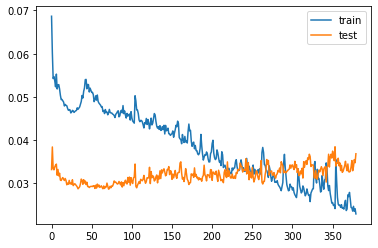

<Figure size 432x288 with 0 Axes>

In [156]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
plt.savefig("training loss 400epochs_5layers")

In [157]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.0383765791689879
overall val_loss 0.031997996661812064


In [158]:
predicted_y = model.predict(test_X)


In [159]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [160]:
predicted_y = predicted_y.reshape(62880,)
test_y = test_y.reshape(62880,)

In [161]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  print('MAE : ',mae)
  print('RMSE : ',rmse)
  print('R2 : ',r2)
  print('Pearson : ',pearson_corr)
  print('Spearman : ',spearman_corr,'\n')


In [162]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence & arousal 
MAE :  0.1475638731589547
RMSE :  0.1919842979894262
R2 :  0.1950741913777273
Pearson :  (0.567250087053418, 0.0)
Spearman :  SpearmanrResult(correlation=0.5726375198437664, pvalue=0.0) 



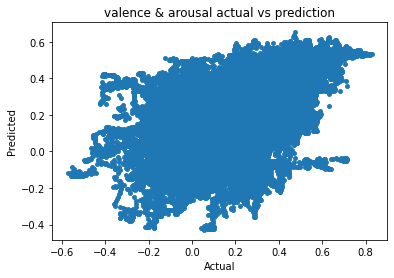

In [163]:
metrics(test_y,predicted_y,'valence & arousal')
graph_results(test_y,predicted_y,'valence & arousal actual vs prediction')
